<a href="https://colab.research.google.com/github/veronicaramirezl/BreastCA-scikit/blob/main/Breast_cancer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Breast cancer classification algorithm

'''
Using the sickit learn toy dataset "Breast Cancer Wisconsin" I will create a classsification convolutional neural network.
'''

# Import libraries

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import requests
from sklearn.datasets import load_breast_cancer


In [2]:
# Load the data

df = sklearn.datasets.load_breast_cancer()
X,y =load_breast_cancer(return_X_y= True)
print(y.shape, X.shape)

(569,) (569, 30)


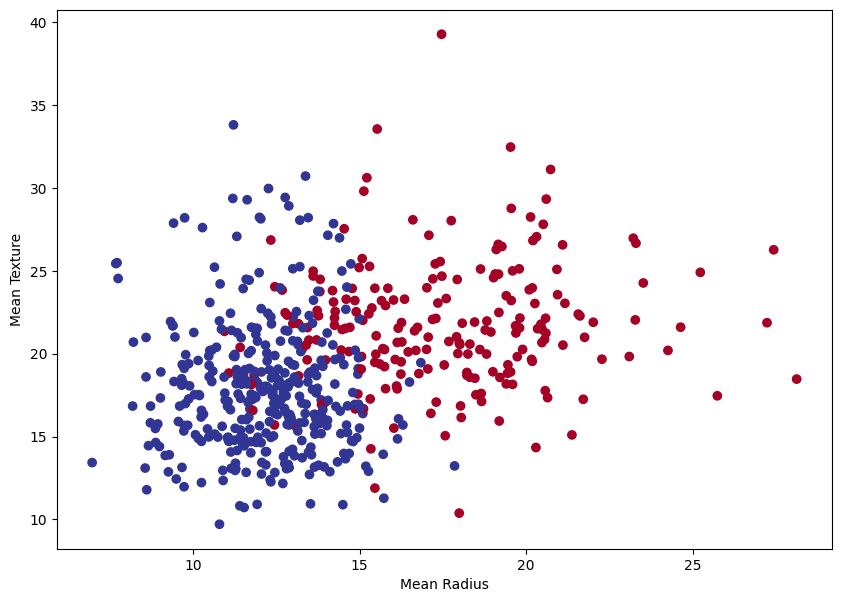

In [3]:
# plot

plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.xlabel("Mean Radius")
plt.ylabel("Mean Texture")
plt.show()

In [4]:

df= pd.DataFrame(df.data, columns=df.feature_names)

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# create device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Lets convert the data to tensors
X = torch.from_numpy(X).type(torch.float)                                        # Converting data to tensors from arrays
y = torch.from_numpy(y).type(torch.float)

# Lets split the training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(X, y,                         # Splitting the data into training and testing sets
                                                    test_size = 0.2,
                                                    random_state = 42)

In [7]:
# Create the model

class  NonLinearModel(nn.Module):
    def __init__(self):
        super().__init__()

        '''
        Initializing the model.
        inputs: number of inputs
        outputs: number of outputs (will be one number)
        hidden_layers: number of hidden layers

        Output: logits
        '''

        self.layer_1 = nn.Linear(in_features=30, out_features=60)
        self.layer_2 = nn.Linear(in_features = 60, out_features=60)
        self.layer_3 = nn.Linear(in_features=60, out_features=1)
        self.relu = nn.ReLU()                                                     # ReLU is a non lnear activation function

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = NonLinearModel().to(device)


In [8]:
# Define a loss function, an optimizer and the accuracy function

loss_fn = nn.BCEWithLogitsLoss()                                                  # Binary cross entropy with logits loss function
#optimize with adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

accuracy_fn = lambda y_true, y_pred: (y_true == y_pred).sum() / len(y_true)

In [9]:
# Train and test the model!

torch.manual_seed(42)
epochs = 100

# Device agnostic code

X_test, X_train = X_test.to(device), X_train.to(device)
y_test, y_train = y_test.to(device), y_train.to(device)

# Save the epoch and loss values for later
train_loss_values = []
test_loss_values = []
epoch_count = []

# Model training

for epoch in range(epochs):
  model.train()
  y_logits = model(X_train).squeeze()
  activation = torch.sigmoid(y_logits)
  y_pred = torch.round(activation)
  loss = loss_fn(y_logits, y_train)
  accuracy_train = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Evaluating the model
  model.eval()
  with torch.inference_mode():
    y_test_logits = model(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
    loss_test = loss_fn(y_test_logits, y_test)
    accuracy_test = accuracy_fn(y_test, y_test_pred)

  # Print the model
  if epoch % 5 == 0:
    '''
    I will also save the epoch, tain and test loss values
    to create a loss plot
    '''
    epoch_count.append(epoch)
    train_loss_values.append(loss.cpu().detach().numpy())
    test_loss_values.append(loss_test.cpu().detach().numpy())
    print(f"Epoch: {epoch} | Loss: {loss: .5f} | Accuracy: {accuracy_train*100: .2f}% | Test Loss: {loss_test: .5f} | Test Accuracy: {accuracy_test*100: .2f}%")

Epoch: 0 | Loss:  14.31434 | Accuracy:  37.14% | Test Loss:  42.25928 | Test Accuracy:  62.28%
Epoch: 5 | Loss:  16.56880 | Accuracy:  37.14% | Test Loss:  15.79011 | Test Accuracy:  37.72%
Epoch: 10 | Loss:  0.44336 | Accuracy:  79.78% | Test Loss:  4.71516 | Test Accuracy:  62.28%
Epoch: 15 | Loss:  0.35835 | Accuracy:  91.21% | Test Loss:  1.07203 | Test Accuracy:  37.72%
Epoch: 20 | Loss:  0.67493 | Accuracy:  55.82% | Test Loss:  0.31395 | Test Accuracy:  89.47%
Epoch: 25 | Loss:  0.36455 | Accuracy:  91.65% | Test Loss:  0.35956 | Test Accuracy:  93.86%
Epoch: 30 | Loss:  0.34111 | Accuracy:  90.99% | Test Loss:  0.27835 | Test Accuracy:  92.11%
Epoch: 35 | Loss:  0.32600 | Accuracy:  88.57% | Test Loss:  0.25090 | Test Accuracy:  92.98%
Epoch: 40 | Loss:  0.31291 | Accuracy:  90.99% | Test Loss:  0.23797 | Test Accuracy:  94.74%
Epoch: 45 | Loss:  0.29358 | Accuracy:  90.11% | Test Loss:  0.21545 | Test Accuracy:  91.23%
Epoch: 50 | Loss:  0.27642 | Accuracy:  91.21% | Test Loss

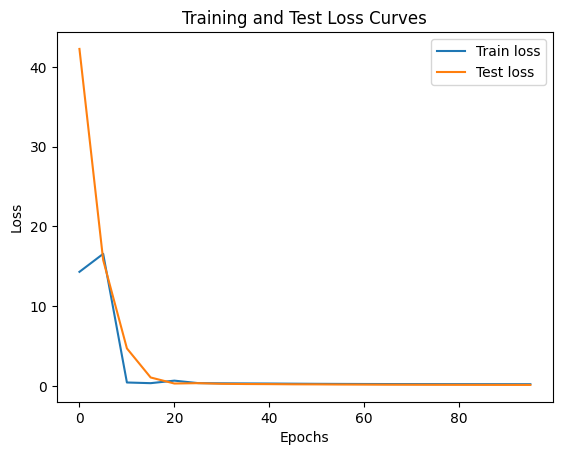

In [10]:
# Graph the Loss
plt.plot(epoch_count, train_loss_values, label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Training and Test Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



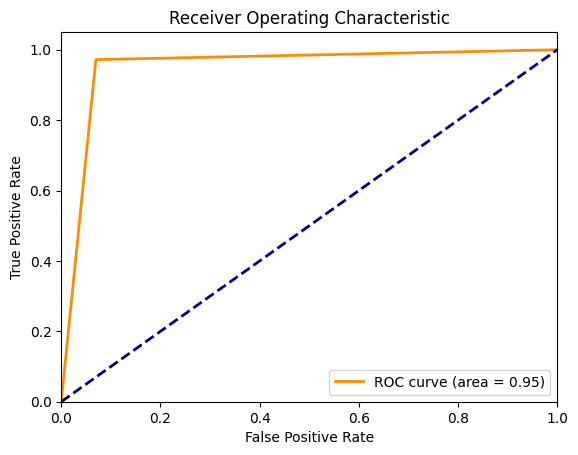

In [11]:
# Plot ROC curve

#Convert tensors to numpy
y_test = y_test.cpu().detach().numpy()
y_test_pred = y_test_pred.cpu().detach().numpy()

# Create the AUC function
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()